In [1]:
# LSTM for Sunspot Number Analysis
# based on https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [2]:
# imports
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)):
        if i + look_back < len(dataset):
            dataY.append(dataset[i + look_back, 0])
        else: 
            dataY.append(0)
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
    return numpy.array(dataX), numpy.array(dataY)

In [4]:
# graphic cleanup and initialization function
def initPyPlot(h=8):
    plt.close()
    figprops = dict(figsize=(11,h), dpi=96)
    fig = plt.figure(**figprops)
    return plt.axes()

In [5]:
# loss logging each N epochs
class NEpochsLogger(tf.keras.callbacks.Callback):
    def __init__(self,display=10):
        '''
        display: Number of epochs to wait before outputting loss
        '''
        self.display = display

    def on_epoch_end(self, epoch, logs={}):    
        if epoch % self.display == 0:
            print ('Epoch {0} -> loss: {1}'.format(epoch,logs.get('loss')))

In [6]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pd.read_csv('data/SN_m_tot_V2.0.csv',sep=';',usecols=[2,3], engine='python')
time = dataframe['DATEFRACTION']
ssn = dataframe['SSN']
# TODO smooth ssn
orig_dataset=ssn.values.reshape(-1,1)

In [7]:
orig_dataset = orig_dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(orig_dataset)

In [8]:
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainXR = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testXR = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [286]:
# create and fit the LSTM network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(1, look_back), recurrent_dropout=0.15))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1,activation='relu'))
model.compile(loss='poisson', optimizer='nadam')

In [287]:
# TODO tensorboard
model.fit(trainXR, trainY, epochs=200, batch_size=768, verbose=0, callbacks=[NEpochsLogger()])

Epoch 0 -> loss: 0.9525526950525683
Epoch 10 -> loss: 0.5437576460283856
Epoch 20 -> loss: 0.5059410405713458
Epoch 30 -> loss: 0.4949818088564762
Epoch 40 -> loss: 0.49077907537305077
Epoch 50 -> loss: 0.48604837905528936
Epoch 60 -> loss: 0.4802044451236725
Epoch 70 -> loss: 0.47370543660119524
Epoch 80 -> loss: 0.47066751884859664
Epoch 90 -> loss: 0.46987734423127286
Epoch 100 -> loss: 0.47034525815830674
Epoch 110 -> loss: 0.4697244660798893
Epoch 120 -> loss: 0.47004016221955763
Epoch 130 -> loss: 0.4697299160236536
Epoch 140 -> loss: 0.46972304929134456
Epoch 150 -> loss: 0.4695839750212292
Epoch 160 -> loss: 0.4695791721343994
Epoch 170 -> loss: 0.46969366142916125
Epoch 180 -> loss: 0.4693068098190219
Epoch 190 -> loss: 0.46957196191299794


In [288]:
# make predictions
trainPredict = model.predict(trainXR)
testPredict = model.predict(testXR)
# rescale predictions
trainPredictI = scaler.inverse_transform(trainPredict)
trainYI = scaler.inverse_transform([trainY])
testPredictI = scaler.inverse_transform(testPredict)
testYI = scaler.inverse_transform([testY])

In [289]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYI[0], trainPredictI[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYI[0], testPredictI[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 27.90 RMSE
Test Score: 25.36 RMSE


In [290]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredictI)+look_back, :] = trainPredictI
trainPredictPlot[0:len(trainPredictI):,] = trainPredictI

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
#testPredictPlot[len(trainPredictI)+(look_back*2)+1:len(dataset)-1, :] = testPredictI
testPredictPlot[len(trainPredictI):len(dataset) :,] = testPredictI

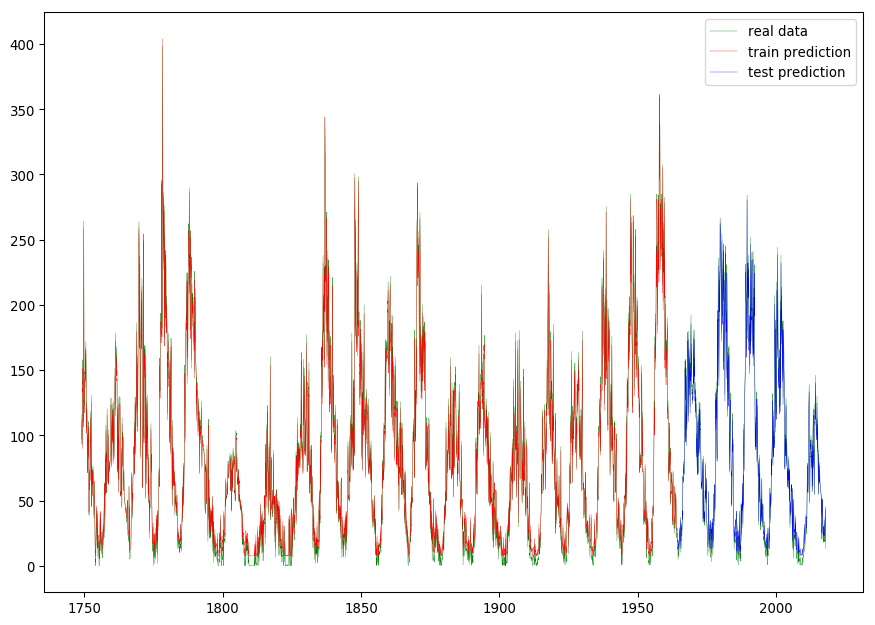

In [291]:
# plot baseline and predictions
ax=initPyPlot()
p1,=ax.plot(time,orig_dataset,antialiased=True,color="green",linewidth=0.25)
p2,=ax.plot(time,trainPredictPlot,color="red",linewidth=0.25,antialiased=True)
p3,=ax.plot(time,testPredictPlot,color="blue",linewidth=0.25,antialiased=True)
ax.legend([p1,p2,p3],['real data','train prediction','test prediction'])
plt.show()

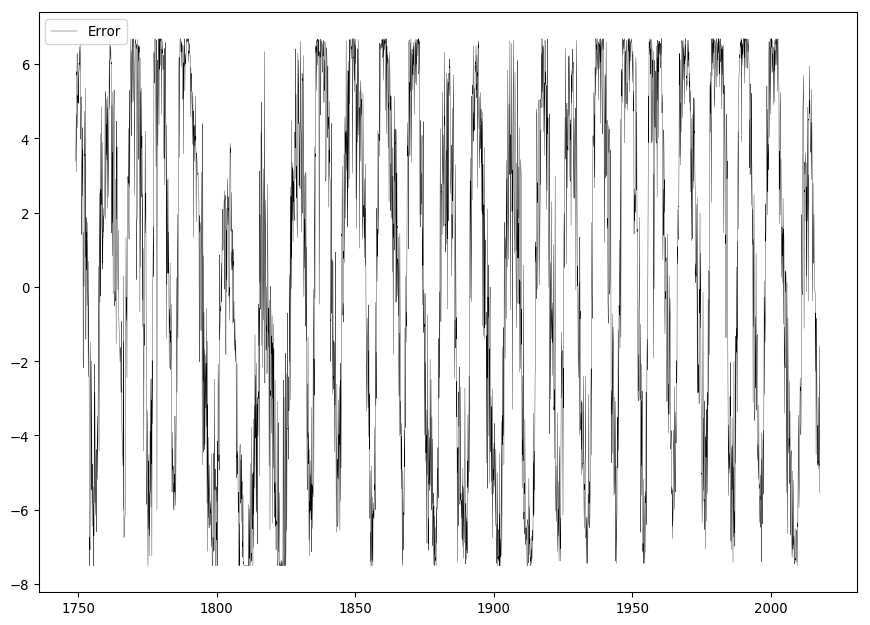

In [292]:
# plot error
bx=initPyPlot()
delta1=orig_dataset[:len(trainPredictI)]-trainPredictI
delta2=orig_dataset[len(trainPredictI):]-testPredictI
delta=numpy.concatenate([delta1.ravel(),delta2.ravel()])
pd,=bx.plot(time,delta,antialiased=True,color="k",linewidth=0.25)
bx.legend([pd],['Error'])
plt.show()